# VEGETABLE OIL

- https://bashtage.github.io/linearmodels/iv/introduction.html
- https://bashtage.github.io/linearmodels/iv/examples/advanced-examples.html
- modelo: https://github.com/rachelsng/Train-Travel-Demand-Modelling-in-Python/blob/main/02_Demand_Modelling_with_2SLS.ipynb

Cap 15 Wooldridge - pg 494

In [1]:
# !pip install linearmodels fredapi --quiet

In [1]:
import pandas as pd
import numpy as np
import linearmodels
import tabulate
import requests
import dateutil.parser

pd.set_option('display.max_columns', None)

# Leitura do Dataset

In [2]:
def get_main():
    df = pd.read_csv('https://raw.githubusercontent.com/fkfouri/vegetable_oil_mkt/master/dataset/COMM5__v4.csv', skiprows=1)
    print(df.shape)
    df['const'] = 1
    df.dropna(axis=1, how='all')
    print(df.shape)

    df['date'] = pd.to_datetime(df['date'])
    # df['date'] = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d'))
    df.set_index('date', inplace=True)
    
#     return df
    return  df[df.index < '2021-01-01']

df_main = get_main()
df_main.head()


(245, 116)
(245, 117)


,reference,A_exports,A_price,A_production,A_share_PROD,A_share_export,A_ΔP,A_ΔQ,A_Cuzada,A_Elasticidade,A_vol_prod,A_vol_exp,A_PnQo,A_balance,B_exports,B_price,B_production,B_share_PROD,B_share_export,B_ΔP,B_ΔQ,B_Cuzada,B_Elasticidade,B_vol_prod,B_vol_exp,B_PnQo,B_balance,C_exports,C_price,C_production,C_share_PROD,C_share_export,C_ΔP,C_ΔQ,C_Cuzada,C_Elasticidade,C_vol_prod,C_vol_exp,C_PnQo,C_balance,D_exports,D_price,D_production,D_share_PROD,D_share_export,D_ΔP,D_ΔQ,D_Cuzada,D_Elasticidade,D_vol_prod,D_vol_exp,D_PnQo,D_balance,E_exports,E_price,E_production,E_share_PROD,E_share_export,E_ΔP,E_ΔQ,E_Cuzada,E_Elasticidade,E_vol_prod,E_vol_exp,E_PnQo,E_balance,prod_total,exp_total,vol_prod_total,vol_expo_total,ΔP_total,ΔQ_total,elasticidade_total,ΣPnQo_total,price_total_exp,price_total_prod,FK IDX CALC PROD,FK IDX CALC EXP,Δ IDX/FAO,FK IDX 5 COMM,Δ IDX/FAO.1,FK IDX 7 COMM,Δ IDX/FAO.2,vegetable-oil_price,vegetable-oil_exports,EXPORT\nDIF USDA,EXPORT\nCALC/USDA,vegetable-oil_production,VOL PROD \nCALC/USDA,vegetable-oil_oecd_exports,EXPORT \nDIF OECD,EXPORT \nCALC/OECD,vegetable-oil_oecd_production,VOL PROD\nCALC/OECD,input_fertilizer_fred_price,input_fertilizer_ureia_price,input_fertilizer_dap_price,input_fertilizer_bloomberg_price,input_clude_oil,africa_eastern_and_southern_income,east_asia_and_pacific_income,europe_and_central_asia_income,high_income_income,latin_america_and_caribbean_income,least_developed_countries_un_classification_income,low_income_income,lower_middle_income_income,middle_east_and_north_africa_income,middle_income_income,north_america_income,oecd_members_income,south_asia_income,sub-saharan_africa_income,upper_middle_income_income,world_income,const
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-31,World,264.00,1224.868,699.42,4.07,3.7,0.132,-0.003,-0.302,0.024,856697.1766,323365.1520,324455.2845,37.7,4004.50,1016.374,6089.33,35.42,56.30,0.102,-0.001,0.699,0.007,6189036.689,4070069.683,3955036.474,65.8,531.92,1097.626,2427.75,14.12,7.50,0.046,0.007,0.0,0.144,2664761.522,583849.2219,368297.4280,21.9,1640.17,1026.196,6381.50,37.12,23.10,0.052,0.000,0.0,0.007,6548669.774,1683135.893,1578166.304,25.7,936.67,1170.020,1592.42,9.26,13.20,0.053,-0.016,0.0,0.307,1863163.248,1.095923e+06,731215.6992,58.8,17190.42,7113.26,18122328.41,7756342.584,0.072,0.079,1.097,6957171.190,1090.406169,1054.210916,128.238,135.707,0.977,130.114,0.992,129.912071,0.990,131.199,7689.17,575.91,0.925101,18658.00,0.921343,7301.11,187.85,0.974271,17908.53,0.959901,307.5,245.0,388.50,410.8200,48.73,90.78,719.03,1617.02,2997.18,465.82,78.12,47.99,158.83,466.45,337.13,4280.70,2604.18,135.62,100.54,572.53,730.62,1
2020-11-30,World,264.85,1073.480,700.35,4.08,3.6,0.285,-0.003,-0.007,0.011,751811.7180,284311.1780,284354.1172,37.8,4007.22,917.810,6088.80,35.43,54.21,0.113,-0.001,0.028,0.006,5588361.528,3677866.588,3571492.409,65.8,528.37,1047.780,2420.51,14.08,7.15,0.122,0.007,0.0,0.055,2536161.968,553615.5186,351572.1012,21.8,1639.60,973.880,6369.82,37.06,22.18,0.063,0.000,0.0,0.006,6203440.302,1596773.648,1497710.574,25.7,952.17,1109.112,1606.51,9.35,12.88,0.122,-0.016,0.0,0.132,1781799.519,1.056063e+06,693150.6355,59.3,17185.99,7392.21,16861575.03,7168630.106,0.103,0.108,1.042,6398279.838,969.754661,981.120000,119.347,120.691,0.979,119.662,0.982,119.158129,0.977,121.903,7704.28,312.07,0.959494,18655.97,0.921206,7289.46,-102.75,1.014096,17889.58,0.960670,292.1,245.0,359.63,384.9375,42.30,91.87,719.85,1623.89,3008.33,474.11,78.25,48.15,159.62,470.50,338.77,4296.22,2614.47,136.48,101.34,575.12,733.87,1
2020-10-31,World,265.71,805.910,701.28,4.08,3.6,0.048,-0.003,-0.041,0.066,565168.5648,214138.3461,213477.4999,37.9,4009.93,819.270,6088.26,35.43,54.14,0.029,-0.001,0.110,0.024,4987928.770,3285215.351,3188041.736,65.9,524.82,927.710,2413.26,14.05,7.09,-0.011,0.007,0.0,0.607,2238805.435,486880.7622,311283.8134,21.7,1639.03,914.770,6358.14,37.01,22.13,0.010,0.000,0.0,0.036,

In [3]:
INCOMES = [col for col in df_main.columns.to_list() if 'income' in col]
INPUTS = [col for col in df_main.columns.to_list() if 'input' in col]
INPUTS

['input_fertilizer_fred_price',
 'input_fertilizer_ureia_price',
 'input_fertilizer_dap_price',
 'input_fertilizer_bloomberg_price',
 'input_clude_oil']

In [4]:
df = df_main[['const', 'exp_total', 'price_total_exp', 'input_fertilizer_dap', 'world_income']]
df

,const,exp_total,price_total_exp,input_fertilizer_dap_price,world_income
date,,,,,
2020-12-31,1,7113.26,1090.406169,388.50,730.62
2020-11-30,1,7392.21,969.754661,359.63,733.87
2020-10-31,1,7407.16,868.786850,357.10,737.12
2020-09-30,1,7422.11,854.031898,358.38,740.37
2020-08-31,1,7437.06,809.940713,341.88,743.62
...,...,...,...,...,...
2002-04-30,1,3151.41,377.847906,147.80,384.42
2002-03-31,1,3123.33,371.064871,149.75,383.43
2002-02-28,1,3095.25,371.687118,150.25,382.43


# OLS - DEMANDA - Tentiva # 1


In [6]:
# A variavel endogena vira Y
y1 = df['exp_total']
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental index_mundi_dap
X1 = df[['const', 'price_total_exp', 'world_income', 'input_fertilizer_dap']]

In [7]:
#encontra o Z chapeu
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error    
import statsmodels.api as sm

# Preciso do treino e teste aqui para capturar r2
lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)
z_hat = lr_modelo.predict(X1)

In [8]:
X2 = df[['const', 'price_total_exp', 'world_income']]
X2['z_hat'] = z_hat
X2

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\630864062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['z_hat'] = z_hat


,const,price_total_exp,world_income,z_hat
date,,,,
2020-12-31,1,1090.406169,730.62,5919.270623
2020-11-30,1,969.754661,733.87,6229.251770
2020-10-31,1,868.786850,737.12,6479.948825
2020-09-30,1,854.031898,740.37,6550.126979
2020-08-31,1,809.940713,743.62,6693.425207
...,...,...,...,...
2002-04-30,1,377.847906,384.42,3229.129972
2002-03-31,1,371.064871,383.43,3229.353014
2002-02-28,1,371.687118,382.43,3215.206055


In [9]:
ols_model = sm.OLS(y1,X2)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:              exp_total   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     500.2
Date:                Tue, 17 May 2022   Prob (F-statistic):           3.27e-99
Time:                        18:12:09   Log-Likelihood:                -1736.6
No. Observations:                 229   AIC:                             3481.
Df Residuals:                     225   BIC:                             3495.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.292e-12    317.584   1.

# OLS em duas etapas [sklearn + statsmodels]

P_HAT

In [5]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [6]:
df = df_main[['const', 'exp_total', 'price_total_exp', 'input_fertilizer_dap', 'world_income']]

In [70]:
# EQ Reduzida

y1 = df['price_total_exp']
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental input_fertilizer_dap_price
X1 = df[['const', 'world_income', 'input_fertilizer_dap']]
lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)
z_hat = lr_modelo.predict(X1)

# EQ Estrutural
y2 = df['exp_total']
X2 = df[['const', 'world_income']]
X2['price_hat'] = z_hat

print('DEMANDA')
ols_model = sm.OLS(y2,X2)
ols_results = ols_model.fit()
print(ols_results.summary())

DEMANDA
                            OLS Regression Results                            
Dep. Variable:              exp_total   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     513.8
Date:                Tue, 17 May 2022   Prob (F-statistic):           8.42e-85
Time:                        23:52:27   Log-Likelihood:                -1773.7
No. Observations:                 229   AIC:                             3553.
Df Residuals:                     226   BIC:                             3564.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -653.9710    201.914     -

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\3779766606.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['price_hat'] = z_hat


# Demanda por IV-2SLS [linearmodels]

In [11]:
# https://github.com/rachelsng/Train-Travel-Demand-Modelling-in-Python/blob/main/02_Demand_Modelling_with_2SLS.ipynb

# Homoskedastic
df_1 = df.copy()

dependent = df_1['exp_total']
exog = df_1.drop(['exp_total', 'price_total_exp', 'input_fertilizer_dap'], axis=1)
exog = sm.add_constant(exog)
endog = df_1[['price_total_exp']]
instruments = df_1[['input_fertilizer_dap_price']]
sm_2sls = linearmodels.IV2SLS(dependent = dependent, exog=exog, endog=endog, instruments=instruments).fit(
    cov_type="unadjusted"
)

print(sm_2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              exp_total   R-squared:                      0.8621
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8609
No. Observations:                 229   F-statistic:                    1361.0
Date:                Tue, May 17 2022   P-value (F-stat)                0.0000
Time:                        18:12:09   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const              -653.97     175.44    -3.7276     0.0002     -997.83     -310.12
world_income        13.027     0

In [12]:
# Heteroskedastic
sm_2sls = linearmodels.IV2SLS(dependent, exog, endog, instruments).fit(cov_type="robust")
print(sm_2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:              exp_total   R-squared:                      0.8621
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8609
No. Observations:                 229   F-statistic:                    3029.5
Date:                Tue, May 17 2022   P-value (F-stat)                0.0000
Time:                        18:12:09   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const              -653.97     103.85    -6.2974     0.0000     -857.51     -450.43
world_income        13.027     0

# OFERTA em duas etapas

Q_HAT

In [13]:
# EQ Reduzida

y1 = df['price_total_exp']
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental input_fertilizer_dap
X1 = df[['const', 'world_income', 'input_fertilizer_dap']]
lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)
p_hat = lr_modelo.predict(X1)

# EQ Estrutural
y2 = df['exp_total']
X2 = df[['const', 'input_fertilizer_dap']]
X2['price_hat'] = p_hat

print('OFERTA')
ols_model = sm.OLS(y2,X2)
ols_results = ols_model.fit()
print(ols_results.summary())

OFERTA
                            OLS Regression Results                            
Dep. Variable:              exp_total   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     513.8
Date:                Tue, 17 May 2022   Prob (F-statistic):           8.42e-85
Time:                        18:12:09   Log-Likelihood:                -1773.7
No. Observations:                 229   AIC:                             3553.
Df Residuals:                     226   BIC:                             3564.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1694.7434    230.2

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\3075232393.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['price_hat'] = p_hat


# Oferta por IV-2SLS

In [14]:
# https://github.com/rachelsng/Train-Travel-Demand-Modelling-in-Python/blob/main/02_Demand_Modelling_with_2SLS.ipynb
df_1 = df.copy()

dependent = df_1['exp_total']
exog = df_1.drop(['exp_total', 'price_total_exp', 'world_income'], axis=1)
exog = sm.add_constant(exog)
endog = df_1[['price_total_exp']]
instruments = df_1[['world_income']]

sm_2sls = linearmodels.IV2SLS(dependent = dependent, exog=exog, endog=endog, instruments=instruments).fit(
    cov_type="unadjusted"
)

print(sm_2sls)


                          IV-2SLS Estimation Summary                          
Dep. Variable:              exp_total   R-squared:                     -3.5221
Estimator:                    IV-2SLS   Adj. R-squared:                -3.5621
No. Observations:                 229   F-statistic:                    41.510
Date:                Tue, May 17 2022   P-value (F-stat)                0.0000
Time:                        18:12:09   Distribution:                  chi2(2)
Cov. Estimator:            unadjusted                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
const              -1694.7     1145.4    -1.4796     0.1390     -3939.7      550.19
index_mundi_dap    -17.843     3

# Statsmodels

In [15]:
from statsmodels.sandbox.regression.gmm import IV2SLS


endo = df_1[['exp_total']]

exog = df_1.drop(['exp_total', 'price_total_exp', 'input_fertilizer_dap'], axis=1)
exog = sm.add_constant(exog)

# iv = df_1[['input_fertilizer_dap','world_income']]
# results = IV2SLS(endog=endog,exog=exog,instrument=instrument).fit()
# print(results.summary())


# y1 = df_1['exp_total']
# exog = df_1.drop(['exp_total', 'price_total_exp', 'world_income'], axis=1)
# exog = sm.add_constant(exog)
# endog = df_1[['price_total_exp']]
# instrument = df_1[['world_income']]


# endog = df[["exp_total"]]
# exog = df[['input_fertilizer_dap', "price_total_exp"]]
# instrument = df[['world_income']]
# results = IV2SLS(endog=endog,exog=exog,instrument=instrument).fit()
# print(results.summary())
# iv

# 2SLS


In [16]:
df

,const,exp_total,price_total_exp,index_mundi_dap,world_income
date,,,,,
2020-12-31,1,7113.26,1090.406169,388.50,730.62
2020-11-30,1,7392.21,969.754661,359.63,733.87
2020-10-31,1,7407.16,868.786850,357.10,737.12
2020-09-30,1,7422.11,854.031898,358.38,740.37
2020-08-31,1,7437.06,809.940713,341.88,743.62
...,...,...,...,...,...
2002-04-30,1,3151.41,377.847906,147.80,384.42
2002-03-31,1,3123.33,371.064871,149.75,383.43
2002-02-28,1,3095.25,371.687118,150.25,382.43


https://bashtage.github.io/linearmodels/iv/examples/advanced-examples.html

In [17]:
def compare_models(df, explicada, explicativa, endogena, VI):
    dados = df.copy()

    
    #OLS
    dependent = dados[explicada]
    exog = dados[explicativa + endogena]
    exog = sm.add_constant(exog)
    endog = None
    instrument = None
    res_ols  = linearmodels.IV2SLS(
        dependent = dependent, exog=exog, endog=endog, instruments=instrument
    ).fit()
   
    #2SLS
    dependent = dados[explicada]
    exog = dados[explicativa]
    exog = sm.add_constant(exog)
    endog = dados[endogena]
    instrument = dados[VI]
    ivmod = linearmodels.IV2SLS(
        dependent = dependent, exog=exog, endog=endog, instruments=instrument )
    
    res_2sls = ivmod.fit()
    res_2sls_std = ivmod.fit(cov_type="unadjusted")
    res_2sls_robust = ivmod.fit(cov_type="robust")

    #GMM
    res_gmm = linearmodels.IVGMM(
        dependent = dependent, exog=exog, endog=endog, instruments=instrument
    ).fit(cov_type="robust")
    
    from collections import OrderedDict
    res = OrderedDict()
    res["OLS"] = res_ols
    res["2SLS"] = res_2sls
    res["2SLS-Homo"] = res_2sls_std
    res["2SLS-Hetero"] = res_2sls_robust
    res["GMM"] = res_gmm


    print(linearmodels.iv.compare(res))
    return res_2sls_robust



# x= compare_models(df, explicada= 'exp_total', explicativa= ['world_income'], endogena= ['price_total_exp'], VI=['index_mundi_dap'] )



# Quantidade em função do Preço

## GIRASSOL

In [18]:
df_main.head()

,reference,A_exports,A_price,A_production,A_share_PROD,A_share_export,A_ΔP,A_ΔQ,A_Cuzada,A_Elasticidade,A_vol_prod,A_vol_exp,A_PnQo,A_balance,B_exports,B_price,B_production,B_share_PROD,B_share_export,B_ΔP,B_ΔQ,B_Cuzada,B_Elasticidade,B_vol_prod,B_vol_exp,B_PnQo,B_balance,C_exports,C_price,C_production,C_share_PROD,C_share_export,C_ΔP,C_ΔQ,C_Cuzada,C_Elasticidade,C_vol_prod,C_vol_exp,C_PnQo,C_balance,D_exports,D_price,D_production,D_share_PROD,D_share_export,D_ΔP,D_ΔQ,D_Cuzada,D_Elasticidade,D_vol_prod,D_vol_exp,D_PnQo,D_balance,E_exports,E_price,E_production,E_share_PROD,E_share_export,E_ΔP,E_ΔQ,E_Cuzada,E_Elasticidade,E_vol_prod,E_vol_exp,E_PnQo,E_balance,prod_total,exp_total,vol_prod_total,vol_expo_total,ΔP_total,ΔQ_total,elasticidade_total,ΣPnQo_total,price_total_exp,price_total_prod,FK IDX CALC PROD,FK IDX CALC EXP,Δ IDX/FAO,FK IDX 5 COMM,Δ IDX/FAO.1,FK IDX 7 COMM,Δ IDX/FAO.2,vegetable-oil_price,vegetable-oil_exports,EXPORT\nDIF USDA,EXPORT\nCALC/USDA,vegetable-oil_production,VOL PROD \nCALC/USDA,vegetable-oil_oecd_exports,EXPORT \nDIF OECD,EXPORT \nCALC/OECD,vegetable-oil_oecd_production,VOL PROD\nCALC/OECD,fred_price_idx,index_mundi_ureia,index_mundi_dap,bloomberg_price_index,clude_oil,africa_eastern_and_southern_income,east_asia_and_pacific_income,europe_and_central_asia_income,high_income_income,latin_america_and_caribbean_income,least_developed_countries_un_classification_income,low_income_income,lower_middle_income_income,middle_east_and_north_africa_income,middle_income_income,north_america_income,oecd_members_income,south_asia_income,sub-saharan_africa_income,upper_middle_income_income,world_income,const
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-31,World,264.00,1224.868,699.42,4.07,3.7,0.132,-0.003,-0.302,0.024,856697.1766,323365.1520,324455.2845,37.7,4004.50,1016.374,6089.33,35.42,56.30,0.102,-0.001,0.699,0.007,6189036.689,4070069.683,3955036.474,65.8,531.92,1097.626,2427.75,14.12,7.50,0.046,0.007,0.0,0.144,2664761.522,583849.2219,368297.4280,21.9,1640.17,1026.196,6381.50,37.12,23.10,0.052,0.000,0.0,0.007,6548669.774,1683135.893,1578166.304,25.7,936.67,1170.020,1592.42,9.26,13.20,0.053,-0.016,0.0,0.307,1863163.248,1.095923e+06,731215.6992,58.8,17190.42,7113.26,18122328.41,7756342.584,0.072,0.079,1.097,6957171.190,1090.406169,1054.210916,128.238,135.707,0.977,130.114,0.992,129.912071,0.990,131.199,7689.17,575.91,0.925101,18658.00,0.921343,7301.11,187.85,0.974271,17908.53,0.959901,307.5,245.0,388.50,410.8200,48.73,90.78,719.03,1617.02,2997.18,465.82,78.12,47.99,158.83,466.45,337.13,4280.70,2604.18,135.62,100.54,572.53,730.62,1
2020-11-30,World,264.85,1073.480,700.35,4.08,3.6,0.285,-0.003,-0.007,0.011,751811.7180,284311.1780,284354.1172,37.8,4007.22,917.810,6088.80,35.43,54.21,0.113,-0.001,0.028,0.006,5588361.528,3677866.588,3571492.409,65.8,528.37,1047.780,2420.51,14.08,7.15,0.122,0.007,0.0,0.055,2536161.968,553615.5186,351572.1012,21.8,1639.60,973.880,6369.82,37.06,22.18,0.063,0.000,0.0,0.006,6203440.302,1596773.648,1497710.574,25.7,952.17,1109.112,1606.51,9.35,12.88,0.122,-0.016,0.0,0.132,1781799.519,1.056063e+06,693150.6355,59.3,17185.99,7392.21,16861575.03,7168630.106,0.103,0.108,1.042,6398279.838,969.754661,981.120000,119.347,120.691,0.979,119.662,0.982,119.158129,0.977,121.903,7704.28,312.07,0.959494,18655.97,0.921206,7289.46,-102.75,1.014096,17889.58,0.960670,292.1,245.0,359.63,384.9375,42.30,91.87,719.85,1623.89,3008.33,474.11,78.25,48.15,159.62,470.50,338.77,4296.22,2614.47,136.48,101.34,575.12,733.87,1
2020-10-31,World,265.71,805.910,701.28,4.08,3.6,0.048,-0.003,-0.041,0.066,565168.5648,214138.3461,213477.4999,37.9,4009.93,819.270,6088.26,35.43,54.14,0.029,-0.001,0.110,0.024,4987928.770,3285215.351,3188041.736,65.9,524.82,927.710,2413.26,14.05,7.09,-0.011,0.007,0.0,0.607,2238805.435,486880.7622,311283.8134,21.7,1639.03,914.770,6358.14,37.01,22.13,0.010,0.000,0.0,0.036,5816235.728,1499335.473,1406806.488,25.8,967.67,981.

In [19]:
df_gir = df_main[['E_exports', 'E_price', 'input_fertilizer_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_gir, explicada= 'E_exports', explicativa= ['world_income'], endogena= ['E_price'], VI=['input_fertilizer_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_gir, explicada= 'E_exports', explicativa= ['input_fertilizer_dap'], endogena= ['E_price'], VI=['world_income'] )

DEMANDA
                                             Model Comparison                                             
                               OLS              2SLS         2SLS-Homo       2SLS-Hetero               GMM
----------------------------------------------------------------------------------------------------------
Dep. Variable            E_exports         E_exports         E_exports         E_exports         E_exports
Estimator                      OLS           IV-2SLS           IV-2SLS           IV-2SLS            IV-GMM
No. Observations               229               229               229               229               229
Cov. Est.                   robust            robust        unadjusted            robust            robust
R-squared                   0.7493            0.7424            0.7424            0.7424            0.7424
Adj. R-squared              0.7471            0.7401            0.7401            0.7401            0.7401
F-statistic                 9

In [20]:
df_gir['q_d'] = d.params['const'] + d.params['E_price']*df_gir['E_price'] + d.params['world_income']*df_gir['world_income']
df_gir

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\1999923629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gir['q_d'] = d.params['const'] + d.params['E_price']*df_gir['E_price'] + d.params['world_income']*df_gir['world_income']


,E_exports,E_price,index_mundi_dap,world_income,q_d
date,,,,,
2020-12-31,936.67,1170.020,388.50,730.62,591.129697
2020-11-30,952.17,1109.112,359.63,733.87,631.661809
2020-10-31,967.67,981.402,357.10,737.12,708.111820
2020-09-30,983.17,982.385,358.38,740.37,715.366564
2020-08-31,998.67,877.140,341.88,743.62,779.737661
...,...,...,...,...,...
2002-04-30,171.53,552.000,147.80,384.42,94.325838
2002-03-31,168.85,557.000,149.75,383.43,89.266546
2002-02-28,166.18,578.000,150.25,382.43,75.580473


In [21]:
df_gir['q_o'] = o.params['const'] + \
                o.params['E_price']*df_gir['E_price'] + \
                o.params['input_fertilizer_dap']*df_gir['input_fertilizer_dap']
df_gir

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\3606033687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gir['q_o'] = o.params['const'] + o.params['E_price']*df_gir['E_price'] + o.params['index_mundi_dap']*df_gir['index_mundi_dap']


,E_exports,E_price,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,936.67,1170.020,388.50,730.62,591.129697,1869.027665
2020-11-30,952.17,1109.112,359.63,733.87,631.661809,1752.205184
2020-10-31,967.67,981.402,357.10,737.12,708.111820,911.278648
2020-09-30,983.17,982.385,358.38,740.37,715.366564,904.799706
2020-08-31,998.67,877.140,341.88,743.62,779.737661,359.909220
...,...,...,...,...,...,...
2002-04-30,171.53,552.000,147.80,384.42,94.325838,146.925735
2002-03-31,168.85,557.000,149.75,383.43,89.266546,160.830899
2002-02-28,166.18,578.000,150.25,382.43,75.580473,298.245823


## Soybean

In [22]:
EXP = 'D_exports'
PRIC = 'D_price'

df_soy = df_main[[EXP, 'D_price', 'input_fertilizer_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_soy, explicada= EXP, explicativa= ['world_income'], endogena= [PRIC], VI=['input_fertilizer_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_soy, explicada= EXP, explicativa= ['index_mundi_dap'], endogena= [PRIC], VI=['world_income'] )

DEMANDA
                                             Model Comparison                                             
                               OLS              2SLS         2SLS-Homo       2SLS-Hetero               GMM
----------------------------------------------------------------------------------------------------------
Dep. Variable            D_exports         D_exports         D_exports         D_exports         D_exports
Estimator                      OLS           IV-2SLS           IV-2SLS           IV-2SLS            IV-GMM
No. Observations               229               229               229               229               229
Cov. Est.                   robust            robust        unadjusted            robust            robust
R-squared                   0.2817            0.2658            0.2658            0.2658            0.2658
Adj. R-squared              0.2754            0.2593            0.2593            0.2593            0.2593
F-statistic                 6

In [23]:
df_soy['q_d'] = d.params['const'] + d.params['D_price']*df_soy['D_price'] + d.params['world_income']*df_soy['world_income']
df_soy['q_d1'] = d.predict()
df_soy['q_o']= o.predict()
df_soy

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\1157028108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soy['q_d'] = d.params['const'] + d.params['D_price']*df_soy['D_price'] + d.params['world_income']*df_soy['world_income']
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\1157028108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soy['q_d1'] = d.predict()
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\1157028108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,D_exports,D_price,index_mundi_dap,world_income,q_d,q_d1,q_o
date,,,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,1393.647006,1393.647006,1483.192528
2020-11-30,1639.60,973.880,359.63,733.87,1410.152854,1410.152854,1477.001856
2020-10-31,1639.03,914.770,357.10,737.12,1428.561902,1428.561902,1444.513460
2020-09-30,1638.46,905.860,358.38,740.37,1432.908450,1432.908450,1438.208664
2020-08-31,1637.89,866.940,341.88,743.62,1445.661684,1445.661684,1429.385811
...,...,...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,1380.094951,1380.094951,1303.175995
2002-03-31,1196.17,359.210,149.75,383.43,1382.794740,1382.794740,1294.698186
2002-02-28,1186.22,364.920,150.25,382.43,1380.625787,1380.625787,1297.619985


## Canola

In [24]:
EXP = 'C_exports'
PRIC = 'C_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_temp, explicada= EXP, explicativa= ['world_income'], endogena= [PRIC], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= EXP, explicativa= ['index_mundi_dap'], endogena= [PRIC], VI=['world_income'] )



DEMANDA
                                             Model Comparison                                             
                               OLS              2SLS         2SLS-Homo       2SLS-Hetero               GMM
----------------------------------------------------------------------------------------------------------
Dep. Variable            C_exports         C_exports         C_exports         C_exports         C_exports
Estimator                      OLS           IV-2SLS           IV-2SLS           IV-2SLS            IV-GMM
No. Observations               229               229               229               229               229
Cov. Est.                   robust            robust        unadjusted            robust            robust
R-squared                   0.8332            0.8222            0.8222            0.8222            0.8222
Adj. R-squared              0.8318            0.8206            0.8206            0.8206            0.8206
F-statistic                 1

In [25]:
df_temp['q_d'] = d.predict()
df_temp['q_o'] = o.predict()
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\2995182159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_d'] = d.predict()
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\2995182159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_o'] = o.predict()


,C_exports,C_price,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,531.92,1097.626,388.50,730.62,315.734802,594.744218
2020-11-30,528.37,1047.780,359.63,733.87,334.079769,560.589457
2020-10-31,524.82,927.710,357.10,737.12,372.445972,339.690233
2020-09-30,521.27,938.140,358.38,740.37,373.605930,356.685606
2020-08-31,517.72,921.550,341.88,743.62,382.469433,359.573911
...,...,...,...,...,...,...
2002-04-30,82.75,410.770,147.80,384.42,71.236669,-200.913479
2002-03-31,83.60,415.850,149.75,383.43,68.529174,-195.379993
2002-02-28,84.46,423.450,150.25,382.43,65.090495,-182.100922


## PALM

In [26]:
EXP = 'B_exports'
PRIC = 'B_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_temp, explicada= EXP, explicativa= ['world_income'], endogena= [PRIC], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= EXP, explicativa= ['index_mundi_dap'], endogena= [PRIC], VI=['world_income'] )



DEMANDA
                                             Model Comparison                                             
                               OLS              2SLS         2SLS-Homo       2SLS-Hetero               GMM
----------------------------------------------------------------------------------------------------------
Dep. Variable            B_exports         B_exports         B_exports         B_exports         B_exports
Estimator                      OLS           IV-2SLS           IV-2SLS           IV-2SLS            IV-GMM
No. Observations               229               229               229               229               229
Cov. Est.                   robust            robust        unadjusted            robust            robust
R-squared                   0.9022            0.8974            0.8974            0.8974            0.8974
Adj. R-squared              0.9013            0.8965            0.8965            0.8965            0.8965
F-statistic                 4

In [27]:
df_temp['q_d'] = d.predict()
df_temp['q_o'] = o.predict()
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\2995182159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_d'] = d.predict()
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\2995182159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_o'] = o.predict()


,B_exports,B_price,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,4004.50,1016.374,388.50,730.62,3342.116889,6008.006875
2020-11-30,4007.22,917.810,359.63,733.87,3518.285845,5203.865010
2020-10-31,4009.93,819.270,357.10,737.12,3694.418299,4133.235734
2020-09-30,4012.65,796.220,358.38,740.37,3755.737928,3863.842885
2020-08-31,4015.36,760.300,341.88,743.62,3836.631554,3631.336364
...,...,...,...,...,...,...
2002-04-30,1559.83,360.070,147.80,384.42,1542.689909,1144.318266
2002-03-31,1543.88,359.000,149.75,383.43,1536.317203,1112.666248
2002-02-28,1527.92,352.980,150.25,382.43,1537.392148,1040.630441


## PALM KERNEL

In [28]:
EXP = 'A_exports'
PRIC = 'A_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_temp, explicada= EXP, explicativa= ['world_income'], endogena= [PRIC], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= EXP, explicativa= ['index_mundi_dap'], endogena= [PRIC], VI=['world_income'] )



DEMANDA
                                             Model Comparison                                             
                               OLS              2SLS         2SLS-Homo       2SLS-Hetero               GMM
----------------------------------------------------------------------------------------------------------
Dep. Variable            A_exports         A_exports         A_exports         A_exports         A_exports
Estimator                      OLS           IV-2SLS           IV-2SLS           IV-2SLS            IV-GMM
No. Observations               229               229               229               229               229
Cov. Est.                   robust            robust        unadjusted            robust            robust
R-squared                   0.9486            0.9420            0.9420            0.9420            0.9420
Adj. R-squared              0.9482            0.9415            0.9415            0.9415            0.9415
F-statistic                 6

In [29]:
df_temp['q_d'] = d.predict()
df_temp['q_o'] = o.predict()
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\2995182159.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_d'] = d.predict()
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\2995182159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_o'] = o.predict()


,A_exports,A_price,index_mundi_dap,world_income,q_d,q_o
date,,,,,,
2020-12-31,264.00,1224.868,388.50,730.62,251.341121,311.476481
2020-11-30,264.85,1073.480,359.63,733.87,257.039475,275.069189
2020-10-31,265.71,805.910,357.10,737.12,266.106482,200.640526
2020-09-30,266.56,767.840,358.38,740.37,268.519224,189.709881
2020-08-31,267.42,739.170,341.88,743.62,270.659418,185.108346
...,...,...,...,...,...,...
2002-04-30,131.19,405.000,147.80,384.42,135.682928,131.839987
2002-03-31,130.83,353.240,149.75,383.43,136.784972,116.935081
2002-02-28,130.47,356.000,150.25,382.43,136.302203,117.604308


## PROXY

In [30]:
EXP = 'exp_total'
PRIC = 'price_total_exp'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
print('DEMANDA')
d = compare_models(df_temp, explicada= EXP, explicativa= ['world_income'], endogena= [PRIC], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= EXP, explicativa= ['index_mundi_dap'], endogena= [PRIC], VI=['world_income'] )



DEMANDA
                                             Model Comparison                                             
                               OLS              2SLS         2SLS-Homo       2SLS-Hetero               GMM
----------------------------------------------------------------------------------------------------------
Dep. Variable            exp_total         exp_total         exp_total         exp_total         exp_total
Estimator                      OLS           IV-2SLS           IV-2SLS           IV-2SLS            IV-GMM
No. Observations               229               229               229               229               229
Cov. Est.                   robust            robust        unadjusted            robust            robust
R-squared                   0.8664            0.8621            0.8621            0.8621            0.8621
Adj. R-squared              0.8652            0.8609            0.8609            0.8609            0.8609
F-statistic                 3

In [31]:
df_temp['q_d'] = d.predict()
df_temp['q_o'] = o.predict()
df_temp['q_m'] = (df_temp['q_d'] + df_temp['q_o'])/2
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\4227588548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_d'] = d.predict()
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\4227588548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_o'] = o.predict()
C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\4227588548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,exp_total,price_total_exp,index_mundi_dap,world_income,q_d,q_o,q_m
date,,,,,,,
2020-12-31,7113.26,1090.406169,388.50,730.62,5741.092891,10222.468602,7981.780746
2020-11-30,7392.21,969.754661,359.63,733.87,6128.937020,8651.968832,7390.452926
2020-10-31,7407.16,868.786850,357.10,737.12,6460.413383,6951.752305,6706.082844
2020-09-30,7422.11,854.031898,358.38,740.37,6545.003893,6673.855426,6609.429660
2020-08-31,7437.06,809.940713,341.88,743.62,6713.603922,6206.085947,6459.844934
...,...,...,...,...,...,...,...
2002-04-30,3151.41,377.847906,147.80,384.42,3271.754302,2199.703199,2735.728750
2002-03-31,3123.33,371.064871,149.75,383.43,3278.282203,2047.656606,2662.969404
2002-02-28,3095.25,371.687118,150.25,382.43,3263.473496,2049.491620,2656.482558


In [32]:
df_temp['q_m'] = (df_temp['q_d'] + df_temp['q_o'])/2
df_temp

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\1833797238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['q_m'] = (df_temp['q_d'] + df_temp['q_o'])/2


,exp_total,price_total_exp,index_mundi_dap,world_income,q_d,q_o,q_m
date,,,,,,,
2020-12-31,7113.26,1090.406169,388.50,730.62,5741.092891,10222.468602,7981.780746
2020-11-30,7392.21,969.754661,359.63,733.87,6128.937020,8651.968832,7390.452926
2020-10-31,7407.16,868.786850,357.10,737.12,6460.413383,6951.752305,6706.082844
2020-09-30,7422.11,854.031898,358.38,740.37,6545.003893,6673.855426,6609.429660
2020-08-31,7437.06,809.940713,341.88,743.62,6713.603922,6206.085947,6459.844934
...,...,...,...,...,...,...,...
2002-04-30,3151.41,377.847906,147.80,384.42,3271.754302,2199.703199,2735.728750
2002-03-31,3123.33,371.064871,149.75,383.43,3278.282203,2047.656606,2662.969404
2002-02-28,3095.25,371.687118,150.25,382.43,3263.473496,2049.491620,2656.482558


#  Preço em função da Quantidade

In [33]:
df_main.head()

,reference,A_exports,A_price,A_production,A_share_PROD,A_share_export,A_ΔP,A_ΔQ,A_Cuzada,A_Elasticidade,A_vol_prod,A_vol_exp,A_PnQo,A_balance,B_exports,B_price,B_production,B_share_PROD,B_share_export,B_ΔP,B_ΔQ,B_Cuzada,B_Elasticidade,B_vol_prod,B_vol_exp,B_PnQo,B_balance,C_exports,C_price,C_production,C_share_PROD,C_share_export,C_ΔP,C_ΔQ,C_Cuzada,C_Elasticidade,C_vol_prod,C_vol_exp,C_PnQo,C_balance,D_exports,D_price,D_production,D_share_PROD,D_share_export,D_ΔP,D_ΔQ,D_Cuzada,D_Elasticidade,D_vol_prod,D_vol_exp,D_PnQo,D_balance,E_exports,E_price,E_production,E_share_PROD,E_share_export,E_ΔP,E_ΔQ,E_Cuzada,E_Elasticidade,E_vol_prod,E_vol_exp,E_PnQo,E_balance,prod_total,exp_total,vol_prod_total,vol_expo_total,ΔP_total,ΔQ_total,elasticidade_total,ΣPnQo_total,price_total_exp,price_total_prod,FK IDX CALC PROD,FK IDX CALC EXP,Δ IDX/FAO,FK IDX 5 COMM,Δ IDX/FAO.1,FK IDX 7 COMM,Δ IDX/FAO.2,vegetable-oil_price,vegetable-oil_exports,EXPORT\nDIF USDA,EXPORT\nCALC/USDA,vegetable-oil_production,VOL PROD \nCALC/USDA,vegetable-oil_oecd_exports,EXPORT \nDIF OECD,EXPORT \nCALC/OECD,vegetable-oil_oecd_production,VOL PROD\nCALC/OECD,fred_price_idx,index_mundi_ureia,index_mundi_dap,bloomberg_price_index,clude_oil,africa_eastern_and_southern_income,east_asia_and_pacific_income,europe_and_central_asia_income,high_income_income,latin_america_and_caribbean_income,least_developed_countries_un_classification_income,low_income_income,lower_middle_income_income,middle_east_and_north_africa_income,middle_income_income,north_america_income,oecd_members_income,south_asia_income,sub-saharan_africa_income,upper_middle_income_income,world_income,const
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-31,World,264.00,1224.868,699.42,4.07,3.7,0.132,-0.003,-0.302,0.024,856697.1766,323365.1520,324455.2845,37.7,4004.50,1016.374,6089.33,35.42,56.30,0.102,-0.001,0.699,0.007,6189036.689,4070069.683,3955036.474,65.8,531.92,1097.626,2427.75,14.12,7.50,0.046,0.007,0.0,0.144,2664761.522,583849.2219,368297.4280,21.9,1640.17,1026.196,6381.50,37.12,23.10,0.052,0.000,0.0,0.007,6548669.774,1683135.893,1578166.304,25.7,936.67,1170.020,1592.42,9.26,13.20,0.053,-0.016,0.0,0.307,1863163.248,1.095923e+06,731215.6992,58.8,17190.42,7113.26,18122328.41,7756342.584,0.072,0.079,1.097,6957171.190,1090.406169,1054.210916,128.238,135.707,0.977,130.114,0.992,129.912071,0.990,131.199,7689.17,575.91,0.925101,18658.00,0.921343,7301.11,187.85,0.974271,17908.53,0.959901,307.5,245.0,388.50,410.8200,48.73,90.78,719.03,1617.02,2997.18,465.82,78.12,47.99,158.83,466.45,337.13,4280.70,2604.18,135.62,100.54,572.53,730.62,1
2020-11-30,World,264.85,1073.480,700.35,4.08,3.6,0.285,-0.003,-0.007,0.011,751811.7180,284311.1780,284354.1172,37.8,4007.22,917.810,6088.80,35.43,54.21,0.113,-0.001,0.028,0.006,5588361.528,3677866.588,3571492.409,65.8,528.37,1047.780,2420.51,14.08,7.15,0.122,0.007,0.0,0.055,2536161.968,553615.5186,351572.1012,21.8,1639.60,973.880,6369.82,37.06,22.18,0.063,0.000,0.0,0.006,6203440.302,1596773.648,1497710.574,25.7,952.17,1109.112,1606.51,9.35,12.88,0.122,-0.016,0.0,0.132,1781799.519,1.056063e+06,693150.6355,59.3,17185.99,7392.21,16861575.03,7168630.106,0.103,0.108,1.042,6398279.838,969.754661,981.120000,119.347,120.691,0.979,119.662,0.982,119.158129,0.977,121.903,7704.28,312.07,0.959494,18655.97,0.921206,7289.46,-102.75,1.014096,17889.58,0.960670,292.1,245.0,359.63,384.9375,42.30,91.87,719.85,1623.89,3008.33,474.11,78.25,48.15,159.62,470.50,338.77,4296.22,2614.47,136.48,101.34,575.12,733.87,1
2020-10-31,World,265.71,805.910,701.28,4.08,3.6,0.048,-0.003,-0.041,0.066,565168.5648,214138.3461,213477.4999,37.9,4009.93,819.270,6088.26,35.43,54.14,0.029,-0.001,0.110,0.024,4987928.770,3285215.351,3188041.736,65.9,524.82,927.710,2413.26,14.05,7.09,-0.011,0.007,0.0,0.607,2238805.435,486880.7622,311283.8134,21.7,1639.03,914.770,6358.14,37.01,22.13,0.010,0.000,0.0,0.036,5816235.728,1499335.473,1406806.488,25.8,967.67,981.

## Soybean

In [34]:
DEPENDENTE = 'D_price'
INDEPENDENTE = 'D_exports'

df_temp = df_main[[DEPENDENTE, INDEPENDENTE, 'index_mundi_dap', 'world_income']].copy()
print('DEMANDA')
d = compare_models(df_temp, explicada= DEPENDENTE, explicativa= ['world_income'], endogena= [INDEPENDENTE], VI=['index_mundi_dap'] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, explicada= DEPENDENTE, explicativa= ['index_mundi_dap'], endogena= [INDEPENDENTE], VI=['world_income'] )

DEMANDA
                                             Model Comparison                                             
                               OLS              2SLS         2SLS-Homo       2SLS-Hetero               GMM
----------------------------------------------------------------------------------------------------------
Dep. Variable              D_price           D_price           D_price           D_price           D_price
Estimator                      OLS           IV-2SLS           IV-2SLS           IV-2SLS            IV-GMM
No. Observations               229               229               229               229               229
Cov. Est.                   robust            robust        unadjusted            robust            robust
R-squared                   0.5910           -1.8245           -1.8245           -1.8245           -1.8245
Adj. R-squared              0.5874           -1.8494           -1.8494           -1.8494           -1.8494
F-statistic                 6

In [35]:
d.params

const           4516.089382
world_income       2.032680
D_exports         -3.569778
Name: parameter, dtype: float64

In [36]:
df_temp['p_d'] = d.predict()
df_temp['p_d2'] = d.params['const'] + d.params[INDEPENDENTE]*df_temp[INDEPENDENTE] + d.params['world_income']*df_temp['world_income']

df_temp['p_o'] = o.predict()
df_temp['p_m'] = (df_temp['p_d'] + df_temp['p_o'])/2
df_temp

,D_price,D_exports,index_mundi_dap,world_income,p_d,p_d2,p_o,p_m
date,,,,,,,,
2020-12-31,1026.196,1640.17,388.50,730.62,146.163702,146.163702,1294.125629,720.144666
2020-11-30,973.880,1639.60,359.63,733.87,154.804685,154.804685,1251.403010,703.103848
2020-10-31,914.770,1639.03,357.10,737.12,163.445669,163.445669,1246.771426,705.108547
2020-09-30,905.860,1638.46,358.38,740.37,172.086652,172.086652,1247.649593,709.868123
2020-08-31,866.940,1637.89,341.88,743.62,180.727636,180.727636,1222.815588,701.771612
...,...,...,...,...,...,...,...,...
2002-04-30,370.860,1206.11,147.80,384.42,991.947605,991.947605,205.187462,598.567533
2002-03-31,359.210,1196.17,149.75,383.43,1025.418842,1025.418842,191.041791,608.230317
2002-02-28,364.920,1186.22,150.25,382.43,1058.905451,1058.905451,174.782165,616.843808


In [37]:
d.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 214.1482
P-value: 0.0000
Distributed: F(1,225)
WaldTestStatistic, id: 0x1559a665990

In [38]:
d.durbin()

Durbin test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 111.6706
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x1559a698880

In [39]:
d.wooldridge_regression

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 81.3942
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x1559a666c50

## Palm - RUIM

In [63]:
DEPENDENTE = 'B_price'
INDEPENDENTE = 'B_exports'


DEMAND_VAR = 'upper_middle_income_income'
# DEMAND_VAR = 'north_america_income'

SUPPLY_VAR = 'index_mundi_dap'
# SUPPLY_VAR = 'bloomberg_price_index'
SUPPLY_VAR = 'fred_price_idx'


df_temp = df_main[[DEPENDENTE, INDEPENDENTE, 
                   'world_income', 'least_developed_countries_un_classification_income', 'upper_middle_income_income', 'middle_income_income', 
                   'index_mundi_ureia', 'index_mundi_dap', 'clude_oil' , 'fred_price_idx']].copy()
print('DEMANDA')
d = compare_models(df_temp, 
                   explicada= DEPENDENTE, 
                   explicativa= ['least_developed_countries_un_classification_income', 'upper_middle_income_income', 'middle_income_income'], 
                   endogena= [INDEPENDENTE], 
                   VI=[SUPPLY_VAR] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, 
                   explicada= DEPENDENTE, 
                   explicativa= ['index_mundi_ureia', 'index_mundi_dap', 'clude_oil'], 
                   endogena= [INDEPENDENTE], 
                   VI=[DEMAND_VAR] )




DEMANDA
                                                            Model Comparison                                                            
                                                                 OLS             2SLS        2SLS-Homo      2SLS-Hetero              GMM
----------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                                                B_price          B_price          B_price          B_price          B_price
Estimator                                                        OLS          IV-2SLS          IV-2SLS          IV-2SLS           IV-GMM
No. Observations                                                 229              229              229              229              229
Cov. Est.                                                     robust           robust       unadjusted           robust           robust
R-squared                        

In [64]:
df_temp['p_d'] = d.predict()
df_temp['p_o'] = o.predict()
df_temp['p_m'] = (df_temp['p_d'] + df_temp['p_o'])/2
df_temp

,B_price,B_exports,world_income,least_developed_countries_un_classification_income,upper_middle_income_income,middle_income_income,index_mundi_ureia,index_mundi_dap,clude_oil,fred_price_idx,p_d,p_o,p_m
date,,,,,,,,,,,,,
2020-12-31,1016.374,4004.50,730.62,78.12,572.53,337.13,245.00,388.50,48.73,307.5,588.790342,702.146278,645.468310
2020-11-30,917.810,4007.22,733.87,78.25,575.12,338.77,245.00,359.63,42.30,292.1,613.733630,650.085549,631.909590
2020-10-31,819.270,4009.93,737.12,78.38,577.71,340.41,245.00,357.10,39.90,286.0,638.692449,636.273854,637.483152
2020-09-30,796.220,4012.65,740.37,78.50,580.30,342.06,250.50,358.38,40.60,286.6,664.128998,638.391107,651.260053
2020-08-31,760.300,4015.36,743.62,78.63,582.88,343.70,249.50,341.88,43.44,280.7,689.243247,642.174215,665.708731
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-04-30,360.070,1559.83,384.42,85.55,133.54,95.19,84.70,147.80,25.43,128.0,794.775851,418.573324,606.674587
2002-03-31,359.000,1543.88,383.43,83.22,133.50,94.76,90.25,149.75,23.64,126.1,816.846746,407.931455,612.389100
2002-02-28,352.980,1527.92,382.43,80.89,133.46,94.33,99.63,150.25,19.98,127.2,838.933174,385.159589,612.046382


In [65]:
 df_temp.iloc[0]

B_price                                               1016.374000
B_exports                                             4004.500000
world_income                                           730.620000
least_developed_countries_un_classification_income      78.120000
upper_middle_income_income                             572.530000
middle_income_income                                   337.130000
index_mundi_ureia                                      245.000000
index_mundi_dap                                        388.500000
clude_oil                                               48.730000
fred_price_idx                                         307.500000
p_d                                                    588.790342
p_o                                                    702.146278
p_m                                                    645.468310
Name: 2020-12-31 00:00:00, dtype: float64

In [67]:
qty = 4004.50
qty2 = 3000
qty3 = 5000
income = df_temp.iloc[0][2]
fertilizer = 307.50
print("OFERTA PRECOS\n ", o.predict(exog = np.array([[1, 245, 388.5, 48.73 ], [1, 245, 388.5, 48.73]]), endog= np.array([[qty], [qty2]])))
print("DEMANDA PRECOS\n", d.predict(exog = np.array([[1, 78.12, 572.53, 337.13], [1, 78.12, 572.53, 337.13]]), endog= np.array([[qty], [qty2]])))

OFERTA PRECOS
     predictions
0   702.146278
1   672.521493
DEMANDA PRECOS
    predictions
0   588.790342
1  2148.943995


In [44]:
d.params

const                                                 1769.005535
least_developed_countries_un_classification_income      -6.480594
upper_middle_income_income                             -15.542975
middle_income_income                                    42.845535
B_exports                                               -1.553164
Name: parameter, dtype: float64

## Canola

In [45]:
DEPENDENTE = 'C_price'
INDEPENDENTE = 'C_exports'
DEMAND_VAR = 'world_income'
DEMAND_VAR = 'middle_income_income'
DEMAND_VAR = 'high_income_income'

SUPPLY_VAR = 'index_mundi_dap'
# SUPPLY_VAR = 'bloomberg_price_index'


df_temp = df_main[[DEPENDENTE, INDEPENDENTE, DEMAND_VAR, SUPPLY_VAR]].copy()
print('DEMANDA')
d = compare_models(df_temp, 
                   explicada= DEPENDENTE, 
                   explicativa= [DEMAND_VAR], 
                   endogena= [INDEPENDENTE], 
                   VI=[SUPPLY_VAR] )
print('-~=' * 40)
print('OFERTA')
o = compare_models(df_temp, 
                   explicada= DEPENDENTE, 
                   explicativa= [SUPPLY_VAR], 
                   endogena= [INDEPENDENTE], 
                   VI=[DEMAND_VAR] )


DEMANDA
                                              Model Comparison                                              
                                 OLS              2SLS         2SLS-Homo       2SLS-Hetero               GMM
------------------------------------------------------------------------------------------------------------
Dep. Variable                C_price           C_price           C_price           C_price           C_price
Estimator                        OLS           IV-2SLS           IV-2SLS           IV-2SLS            IV-GMM
No. Observations                 229               229               229               229               229
Cov. Est.                     robust            robust        unadjusted            robust            robust
R-squared                     0.4736           -0.0367           -0.0367           -0.0367           -0.0367
Adj. R-squared                0.4690           -0.0458           -0.0458           -0.0458           -0.0458
F-statistic

In [46]:
df_temp['p_d'] = d.predict()
df_temp['p_o'] = o.predict()
df_temp['p_m'] = (df_temp['p_d'] + df_temp['p_o'])/2
df_temp

,C_price,C_exports,high_income_income,index_mundi_dap,p_d,p_o,p_m
date,,,,,,,
2020-12-31,1097.626,531.92,2997.18,388.50,253.698812,1030.053757,641.876285
2020-11-30,1047.780,528.37,3008.33,359.63,291.213188,996.256510,643.734849
2020-10-31,927.710,524.82,3019.47,357.10,328.709277,992.009657,660.359467
2020-09-30,938.140,521.27,3030.61,358.38,366.205365,992.037179,679.121272
2020-08-31,921.550,517.72,3041.75,341.88,403.701454,972.117623,687.909539
...,...,...,...,...,...,...,...
2002-04-30,410.770,82.75,1780.77,147.80,196.007480,581.805050,388.906265
2002-03-31,415.850,83.60,1775.89,149.75,182.983279,584.329966,383.656622
2002-02-28,423.450,84.46,1771.02,150.25,169.929126,585.232118,377.580622


# Formas Reduzidas


In [47]:
# α β π ω
def get_parms(d, o):
    α0 = d.params[0]
    α1 = d.params[2]
    α2 = d.params[1]
    
    β0 = o.params[0]
    β1 = o.params[2]
    β2 = o.params[1]
    return α0, α1, α2, β0, β1, β2
    
    
    
def π0(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (α1*β0 + α0*β1) / (α1 - β1)

def π1(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (- α2*β1) / (α1 - β1)

def π2(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (α1*β2) / (α1 - β1)

# def ω1(d, o):
#     α0, α1, α2, β0, β1, β2 = get_parms(d, o)
#     return (α1*β0 + α0*β1) / (α1 - β1)


def π3(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (β0 - α0) / (α1 - β1)

def π4(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (- α2) / (α1 - β1)

def π5(d, o):
    α0, α1, α2, β0, β1, β2 = get_parms(d, o)
    return (β2) / (α1 - β1)

In [48]:
def two_sls(df, explicada, endogena, explicativas, VI):
    dependent = df[explicada]
    endog = df[endogena]
    
    exog = df[explicativas]
    exog = sm.add_constant(exog)

    instruments = df[VI]
    return linearmodels.IV2SLS(dependent=dependent, exog=exog, endog=endog, instruments=instruments).fit(cov_type="robust")



def reducted(dados, explicada, endogena, explicativas, VI):
    df = dados.copy()
    
    demand = two_sls(df, explicada, endogena, explicativas, VI)
    _var = f'{explicada}_demand'
    df[_var] = demand.predict()
    
    supply = two_sls(df, explicada, endogena, VI, explicativas)
    _var = f'{explicada}_supply'
    df[_var] = supply.predict()
    
    
    Q = [π0(demand, supply), π1(demand, supply), π2(demand, supply)]
    P = [π3(demand, supply), π4(demand, supply), π5(demand, supply)]
    
    return df, demand, supply, P, Q

## Proxy

In [49]:
EXP = 'exp_total'
PRIC = 'price_total_exp'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
df_temp, d, o, P, Q = reducted(df_temp, explicada= EXP, endogena= PRIC, explicativas= ['world_income'], VI=['index_mundi_dap'] )

print(P, Q)

[51.651333839576225, 0.6464921805186541, 0.8854917107481097] [320.17574432381883, 11.175448146947176, -2.5357630015201496]


In [50]:
df_temp

,exp_total,price_total_exp,index_mundi_dap,world_income,exp_total_demand,exp_total_supply
date,,,,,,
2020-12-31,7113.26,1090.406169,388.50,730.62,5741.092891,10222.468602
2020-11-30,7392.21,969.754661,359.63,733.87,6128.937020,8651.968832
2020-10-31,7407.16,868.786850,357.10,737.12,6460.413383,6951.752305
2020-09-30,7422.11,854.031898,358.38,740.37,6545.003893,6673.855426
2020-08-31,7437.06,809.940713,341.88,743.62,6713.603922,6206.085947
...,...,...,...,...,...,...
2002-04-30,3151.41,377.847906,147.80,384.42,3271.754302,2199.703199
2002-03-31,3123.33,371.064871,149.75,383.43,3278.282203,2047.656606
2002-02-28,3095.25,371.687118,150.25,382.43,3263.473496,2049.491620


## Soybean


In [51]:
EXP = 'D_exports'
PRIC = 'D_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
df_temp, d, o, P, Q = reducted(df_temp, explicada= EXP, endogena= PRIC, explicativas= ['world_income'], VI=['index_mundi_dap'] )

print(P, Q)
df_temp

[62.31979354738984, 0.6575061794593828, 0.9783530310857801] [-464.1162227304298, 0.38522674032676246, -0.27406553067139683]


,D_exports,D_price,index_mundi_dap,world_income,D_exports_demand,D_exports_supply
date,,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,1393.647006,1483.192528
2020-11-30,1639.60,973.880,359.63,733.87,1410.152854,1477.001856
2020-10-31,1639.03,914.770,357.10,737.12,1428.561902,1444.513460
2020-09-30,1638.46,905.860,358.38,740.37,1432.908450,1438.208664
2020-08-31,1637.89,866.940,341.88,743.62,1445.661684,1429.385811
...,...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,1380.094951,1303.175995
2002-03-31,1196.17,359.210,149.75,383.43,1382.794740,1294.698186
2002-02-28,1186.22,364.920,150.25,382.43,1380.625787,1297.619985


# Rodney

In [52]:
EXP = 'D_exports'
PRIC = 'D_price'

df_temp = df_main[[EXP, PRIC, 'index_mundi_dap', 'world_income']]
df_temp, d, o, P, Q = reducted(df_temp, explicada= EXP, endogena= PRIC, explicativas= ['world_income'], VI=['index_mundi_dap'] )

print(P, Q)
df_temp

[62.31979354738984, 0.6575061794593828, 0.9783530310857801] [-464.1162227304298, 0.38522674032676246, -0.27406553067139683]


,D_exports,D_price,index_mundi_dap,world_income,D_exports_demand,D_exports_supply
date,,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,1393.647006,1483.192528
2020-11-30,1639.60,973.880,359.63,733.87,1410.152854,1477.001856
2020-10-31,1639.03,914.770,357.10,737.12,1428.561902,1444.513460
2020-09-30,1638.46,905.860,358.38,740.37,1432.908450,1438.208664
2020-08-31,1637.89,866.940,341.88,743.62,1445.661684,1429.385811
...,...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,1380.094951,1303.175995
2002-03-31,1196.17,359.210,149.75,383.43,1382.794740,1294.698186
2002-02-28,1186.22,364.920,150.25,382.43,1380.625787,1297.619985


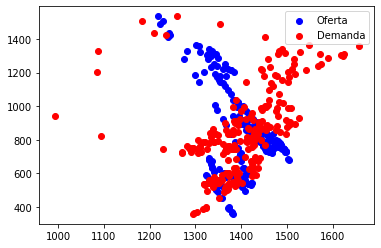

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# plt.style.use('_mpl-gallery')

# make data
x = df_temp['D_exports']
y = df_temp['D_price']

# plot
fig, ax = plt.subplots()

ax.scatter(d.predict(), df_temp['D_price'], label='Oferta', color='b')
ax.scatter(o.predict(), df_temp['D_price'], label='Demanda', color='r')

# ax.scatter(df_temp['D_exports'], df_temp['D_price'], label='Exportacao', color='k')

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

plt.legend()
plt.show()

C:\Users\fkfouri\AppData\Local\Temp\ipykernel_6828\1296184498.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


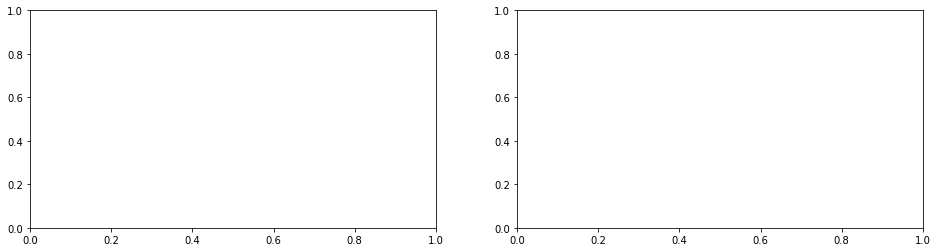

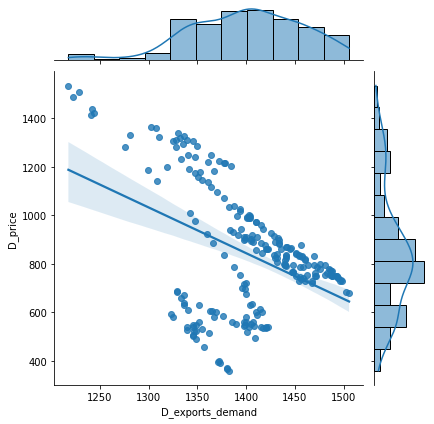

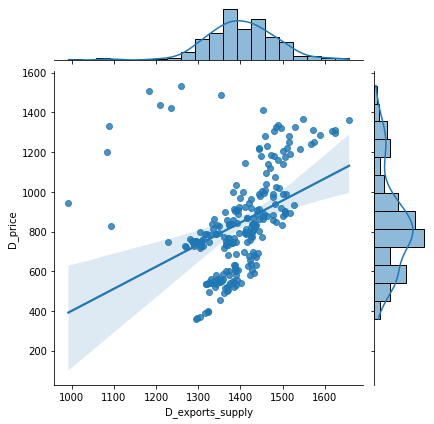

In [54]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1 = sns.jointplot(x=df_temp['D_exports_demand'], y=df_temp['D_price'], kind='reg', ax=ax1)

ax2 = sns.jointplot(x=df_temp['D_exports_supply'], y=df_temp['D_price'], kind='reg', ax=ax2)
fig.show()

In [55]:
df_temp

,D_exports,D_price,index_mundi_dap,world_income,D_exports_demand,D_exports_supply
date,,,,,,
2020-12-31,1640.17,1026.196,388.50,730.62,1393.647006,1483.192528
2020-11-30,1639.60,973.880,359.63,733.87,1410.152854,1477.001856
2020-10-31,1639.03,914.770,357.10,737.12,1428.561902,1444.513460
2020-09-30,1638.46,905.860,358.38,740.37,1432.908450,1438.208664
2020-08-31,1637.89,866.940,341.88,743.62,1445.661684,1429.385811
...,...,...,...,...,...,...
2002-04-30,1206.11,370.860,147.80,384.42,1380.094951,1303.175995
2002-03-31,1196.17,359.210,149.75,383.43,1382.794740,1294.698186
2002-02-28,1186.22,364.920,150.25,382.43,1380.625787,1297.619985


## Terceira Regressao

In [56]:
# SOJA

EXP = 'D_exports_demand'
PRIC = 'D_price'
df = df_temp.copy()
df['const'] = 1


y1 = df[PRIC]
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental index_mundi_dap
X1 = df[['const', EXP]]
ols_model = sm.OLS(y1,X1)
ols_results = ols_model.fit()
print(ols_results.summary())

lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)


                            OLS Regression Results                            
Dep. Variable:                D_price   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     50.71
Date:                Tue, 17 May 2022   Prob (F-statistic):           1.40e-11
Time:                        18:12:17   Log-Likelihood:                -1569.8
No. Observations:                 229   AIC:                             3144.
Df Residuals:                     227   BIC:                             3150.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3485.4854    371.187  

LinearRegression()

In [57]:
lr_modelo.predict(np.array([[1, 900]]))

E:\Projetos\vegetable_oil_mkt\.env-win-tese\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([1787.03673989])

In [58]:
lr_modelo.predict(np.array([1, 747]) )

E:\Projetos\vegetable_oil_mkt\.env-win-tese\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[  1 747].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)
p_hat = lr_modelo.predict(X1)

In [ ]:
EXP = 'D_exports_supply'
PRIC = 'D_price'
df = df_temp.copy()
df['const'] = 1


y1 = df[PRIC]
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental index_mundi_dap
X1 = df[['const', EXP]]
ols_model = sm.OLS(y1,X1)
ols_results = ols_model.fit()
print(ols_results.summary())

In [ ]:
y1 = df['price_total_exp']
# X1 nao tem a variavel endogena exp_total, porem considera a variavel instrumental index_mundi_dap
X1 = df[['const', 'world_income', 'index_mundi_dap']]
lr_modelo = LinearRegression()
lr_modelo.fit(X=X1, y=y1)
p_hat = lr_modelo.predict(X1)

In [ ]:
lr_modelo.coef_